In [55]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [56]:
def calculate_cumulative_variance(estimations):
    variances = np.zeros_like(estimations)
    for i in range(1, len(estimations)):
        variances[i] = np.var(estimations[:(i+1)], ddof=1) # ddof=1 daje nieobciążony estymator
    return variances

def theoretical_call_price(S_0, T, K, sg, r):
    def d_param(S_0, T, K, sg, r, plus):
        return (np.log(S_0/K) + (r+(sg**2)/2)*T)/(sg*np.sqrt(T)) if plus else (np.log(S_0/K) + (r-(sg**2)/2)*T)/(sg*np.sqrt(T))
    return S_0*norm.cdf(d_param(S_0, T, K, sg, r, True)) - K*np.exp(-r*T)*norm.cdf(d_param(S_0, T, K, sg, r, False))

def visualize_method(theoretical_prices, price_estimates, variance_estimates, strikes, method_name, second_col = True):
    plt.figure(figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(price_estimates[0], label="Estimation", color="blue")
    plt.axhline(y=theoretical_prices[0], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[0]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 2)
        plt.plot(variance_estimates[0], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(price_estimates[1], label="Estimation", color="blue")
    plt.axhline(y=theoretical_prices[1], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[1]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 4)
        plt.plot(variance_estimates[1], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()


# Parametry rynku

In [57]:
S_0 = 100
r = 0.1
T = 1
sg = 1
K_1 = 80
K_2 = 120
CALL_1_THEO = theoretical_call_price(S_0, T, K_1, sg, r)
CALL_2_THEO = theoretical_call_price(S_0, T, K_2, sg, r)
title1 = "K = 80"
title2 = "K = 120"

# Inicjacja losowości

In [58]:
np.random.seed(42)
n_samples = 100000
randoms = np.random.normal(0,1,n_samples)
mean_maker = np.arange(1,n_samples+1)
exponent = (sg*np.sqrt(T) * randoms) + (r - (sg**2)/2)*T
stock_prices = S_0*np.exp(exponent)

call_payoffs1 = stock_prices - K_1
call_payoffs2 = stock_prices - K_2

call_payoffs1[call_payoffs1 < 0] = 0
call_payoffs2[call_payoffs2 < 0] = 0

call_payoffs1 *= np.exp(-r*T)
call_payoffs2 *= np.exp(-r*T)


# 1. Wycena Call

## 1.0 czysta woda

In [59]:
#kalkulacja
basic_variances_1 = calculate_cumulative_variance(call_payoffs1)
basic_estimates_1 = np.cumsum(call_payoffs1)
basic_estimates_1/=mean_maker
basic_variances_2 = calculate_cumulative_variance(call_payoffs2)
basic_estimates_2 = np.cumsum(call_payoffs2)
basic_estimates_2/=mean_maker

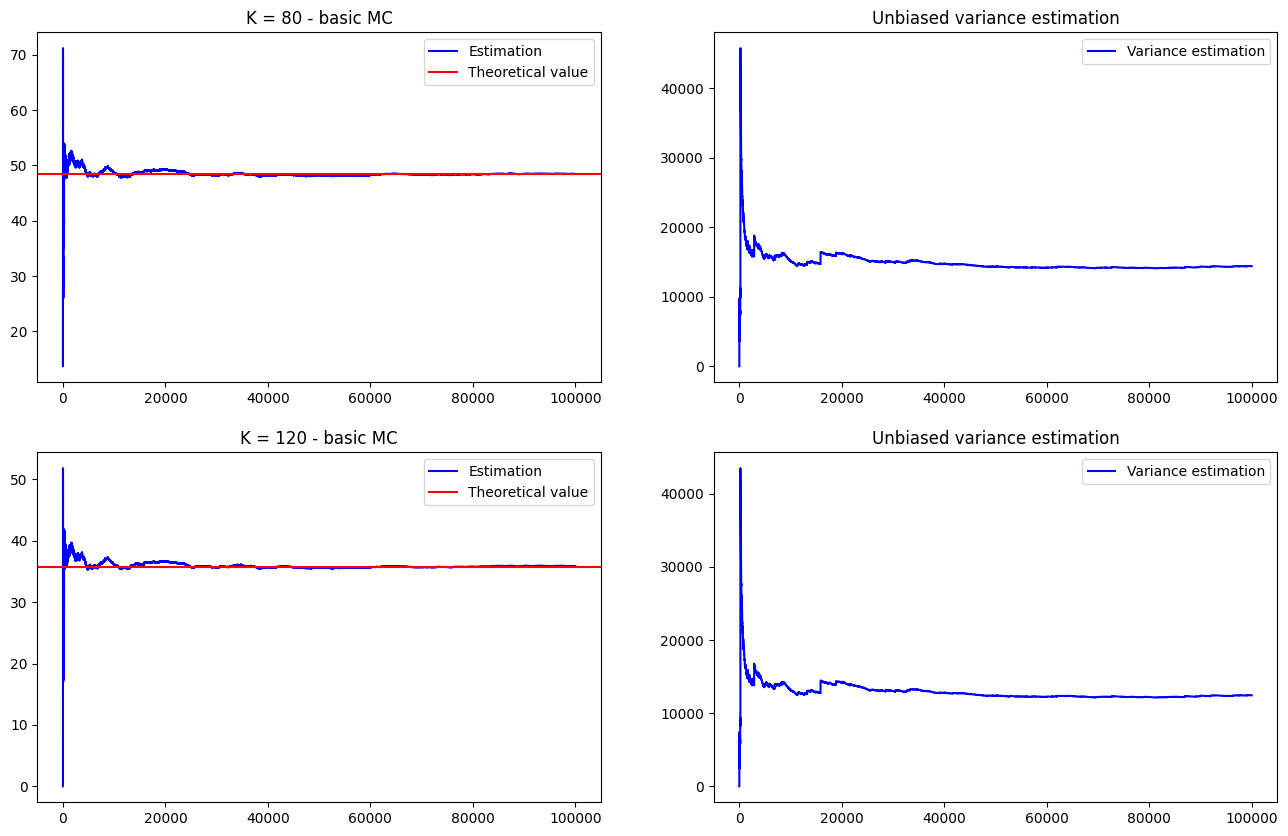

In [60]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [basic_estimates_1, basic_estimates_2], [basic_variances_1,basic_variances_2], [80,120], 'basic MC')
#wykresy są bardzo podobne (w przypadku wariancji identyczne - ta sama losowość)

## 1. a) - zmienna kontrolna

In [61]:
#wartość oczekiwana zmiennej kontrolnej
b = np.exp(-r*T)
tau = S_0*np.exp(r*T)

control_variate_payoffs1 = call_payoffs1 + (tau - stock_prices) * b
control_variate_payoffs2 = call_payoffs2 + (tau - stock_prices) * b

control_variate_variances_1 = calculate_cumulative_variance(control_variate_payoffs1)
control_variate_variances_2 = calculate_cumulative_variance(control_variate_payoffs2)

control_variate_means = (np.cumsum(stock_prices) / mean_maker)

control_variate_estimates_1 = basic_estimates_1 + (tau - control_variate_means) * b
control_variate_estimates_2 = basic_estimates_2 + (tau - control_variate_means) * b

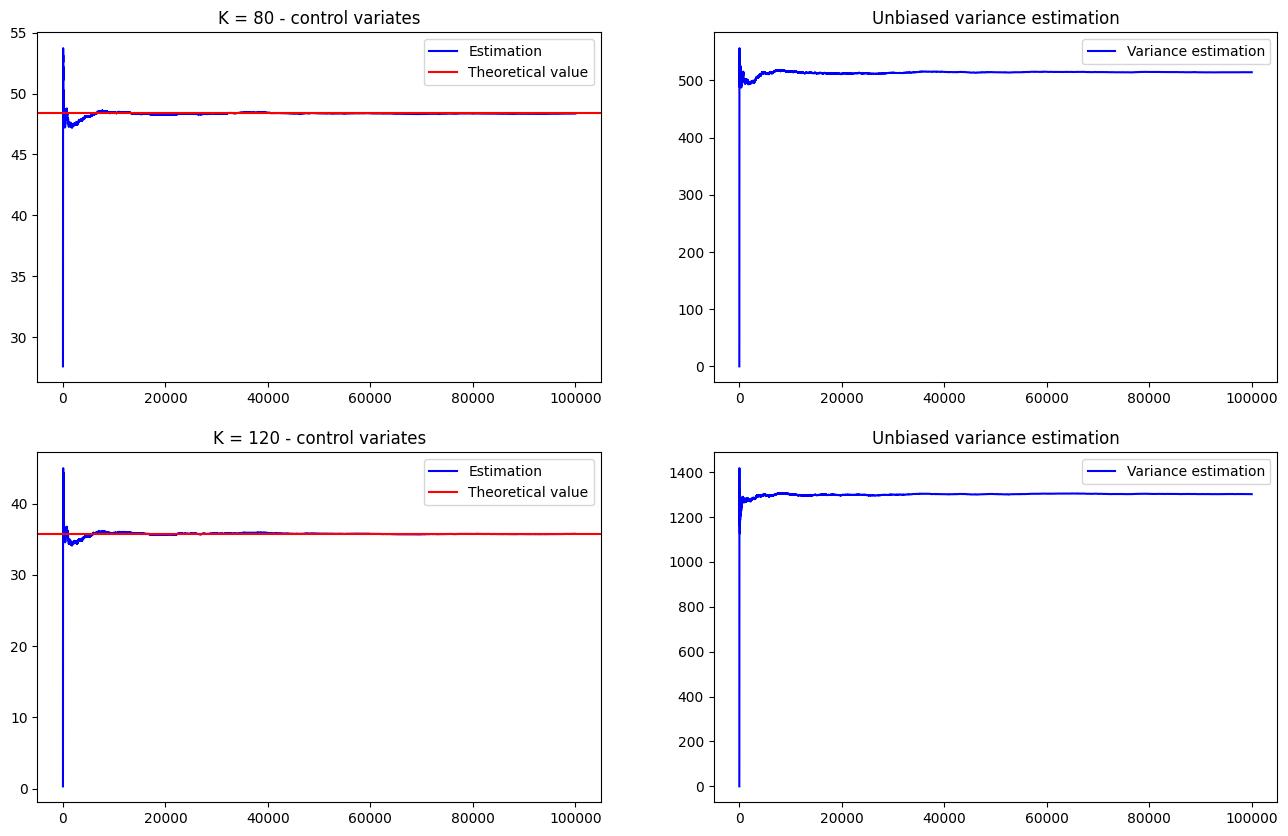

In [62]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimates_1, control_variate_estimates_2], [control_variate_variances_1, control_variate_variances_2], [80,120], 'control variates')

## 1. b) - zmienna kontrolna z wyestymowanym współczynnikiem

In [73]:
#współczynniki b estymujemy dla 1000 próbek
n_small = 1000
randoms_small = np.random.normal(0,1,n_small)
exponent_small = (sg*np.sqrt(T) * randoms_small) + (r - (sg**2)/2)*T
stock_prices_small = S_0*np.exp(exponent_small)

call_payoffs1_small = stock_prices_small - K_1
call_payoffs2_small = stock_prices_small - K_2

call_payoffs1_small[call_payoffs1_small < 0] = 0
call_payoffs2_small[call_payoffs2_small < 0] = 0

call_payoffs1_small *= np.exp(-r*T)
call_payoffs2_small *= np.exp(-r*T)

small_mean1 = np.mean(call_payoffs1_small)
small_mean2 = np.mean(call_payoffs2_small)

centered_payoffs1_small = call_payoffs1_small - small_mean1
centered_payoffs2_small = call_payoffs2_small - small_mean2

control_variate_mean = np.mean(stock_prices_small)
centered_control_variate = stock_prices_small - control_variate_mean

numerator1 = np.sum(centered_payoffs1_small*centered_control_variate)
numerator2 = np.sum(centered_payoffs2_small*centered_control_variate)
denominator = np.sum(centered_control_variate**2)

b1 = numerator1 / denominator
b2 = numerator2 / denominator

control_variate_estimated_coef_payoffs1 = call_payoffs1 + (tau - stock_prices) * b1
control_variate_estimated_coef_payoffs2 = call_payoffs2 + (tau - stock_prices) * b2

control_variate_variances_estimated_coef1 = calculate_cumulative_variance(control_variate_estimated_coef_payoffs1)
control_variate_variances_estimated_coef2 = calculate_cumulative_variance(control_variate_estimated_coef_payoffs2)


control_variate_estimated_coef_estimates1 = basic_estimates_1 + (tau - control_variate_means) * b1
control_variate_estimated_coef_estimates2 = basic_estimates_2 + (tau - control_variate_means) * b2

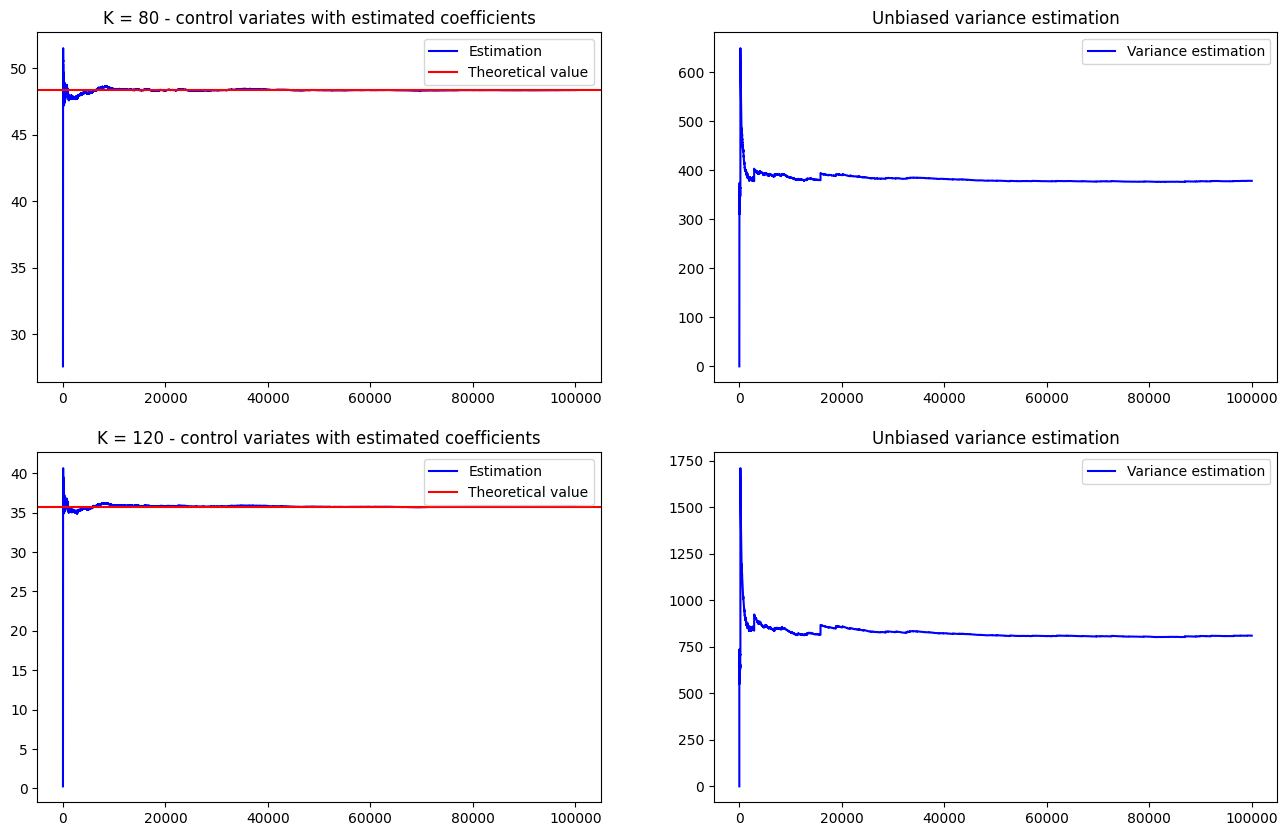

In [74]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimated_coef_estimates1, control_variate_estimated_coef_estimates2], [control_variate_variances_estimated_coef1, control_variate_variances_estimated_coef2], [80,120], 'control variates with estimated coefficients')
#w tym wypadku nie istnieje estymator z pojedynczej próbki w związku z czym nie ma wykresu wariancji

## 1. c) - zmienne antytetyczne

In [65]:
antiexponent = (sg*np.sqrt(T) * (-randoms)) + (r - (sg**2)/2)*T
antistock_prices = S_0*np.exp(antiexponent)

anticall_payoffs1 = antistock_prices - K_1
anticall_payoffs2 = antistock_prices - K_2

anticall_payoffs1[anticall_payoffs1 < 0] = 0
anticall_payoffs2[anticall_payoffs2 < 0] = 0

anticall_payoffs1 *= np.exp(-r*T)
anticall_payoffs2 *= np.exp(-r*T)

merged_payoffs1 = (anticall_payoffs1 + call_payoffs1) / 2
merged_payoffs2 = (anticall_payoffs2 + call_payoffs2) / 2

merged_variances_1 = calculate_cumulative_variance(merged_payoffs1)
merged_estimates_1 = np.cumsum(merged_payoffs1)
merged_estimates_1/=mean_maker
merged_variances_2 = calculate_cumulative_variance(merged_payoffs2)
merged_estimates_2 = np.cumsum(merged_payoffs2)
merged_estimates_2/=mean_maker

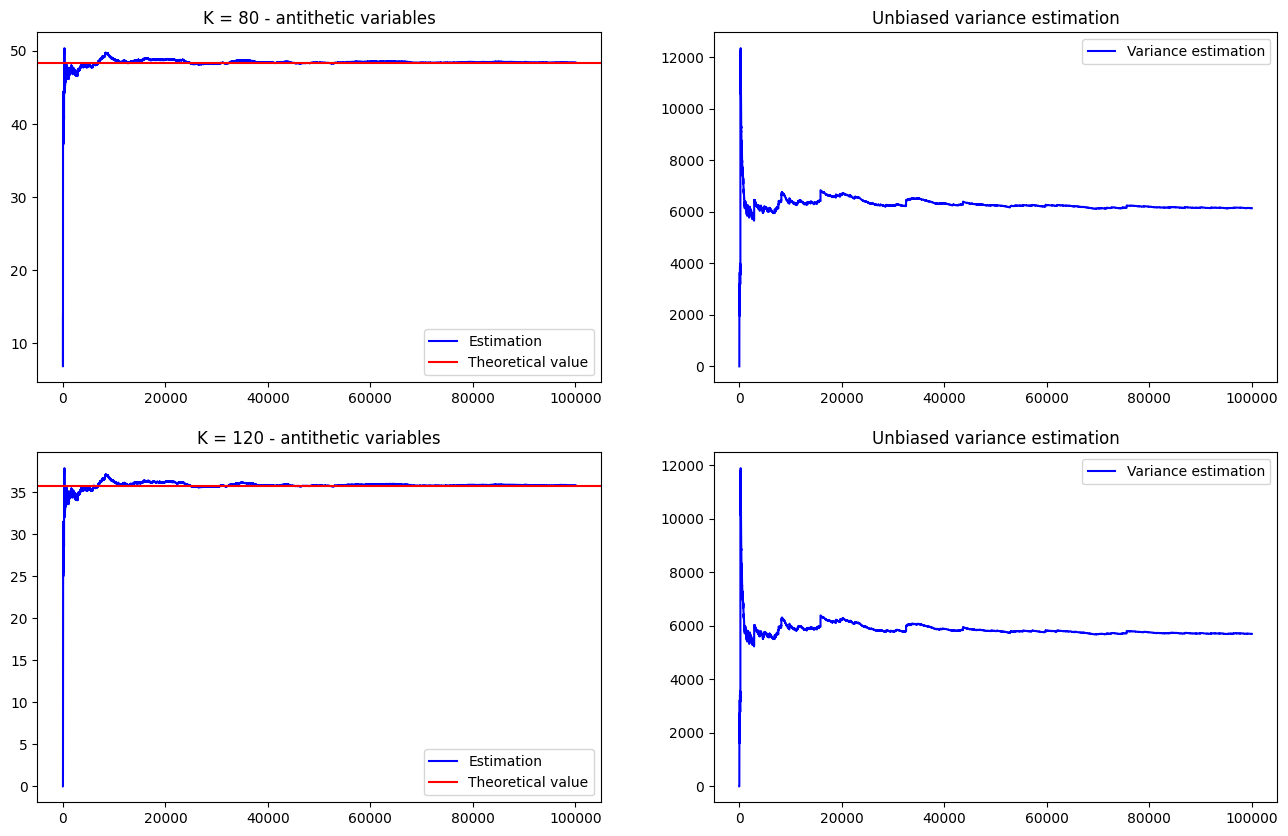

In [66]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [merged_estimates_1, merged_estimates_2], [merged_variances_1, merged_variances_2], [80,120], 'antithetic variables')

## 1. d) - stratified sampling

In [67]:
# wyekstrahujmy jednstostajną losowość z naszej normalnej próbki
uniforms = norm.cdf(randoms)
k = 100
subsamples = [[] for _ in range(k)]
for i in range(k):
    for j in range(n_samples//k):
        idx = i*k + j
        sample = uniforms[idx]
        normal_sample = norm.ppf((i+sample)/k)
        subsamples[i].append(normal_sample)
samples_collected = []
for j in range(n_samples//k):
    for i in range(k):
        samples_collected.append(subsamples[i][j])
# nowe źródło losowości N(0,1) pobrókowane przedziałami przetasowane
samples_collected = np.array(samples_collected)

stratified_exponent = (sg*np.sqrt(T) * samples_collected) + (r - (sg**2)/2)*T
stratified_stock_prices = S_0*np.exp(stratified_exponent)

stratified_call_payoffs1 = stratified_stock_prices - K_1
stratified_call_payoffs2 = stratified_stock_prices - K_2

stratified_call_payoffs1[stratified_call_payoffs1 < 0] = 0
stratified_call_payoffs2[stratified_call_payoffs2 < 0] = 0

stratified_call_payoffs1 *= np.exp(-r*T)
stratified_call_payoffs2 *= np.exp(-r*T)

stratified_variances1 = calculate_cumulative_variance(stratified_call_payoffs1)
stratified_estimates1 = np.cumsum(stratified_call_payoffs1)
stratified_estimates1/=mean_maker

stratified_variances2 = calculate_cumulative_variance(stratified_call_payoffs2)
stratified_estimates2 = np.cumsum(stratified_call_payoffs2)
stratified_estimates2/=mean_maker

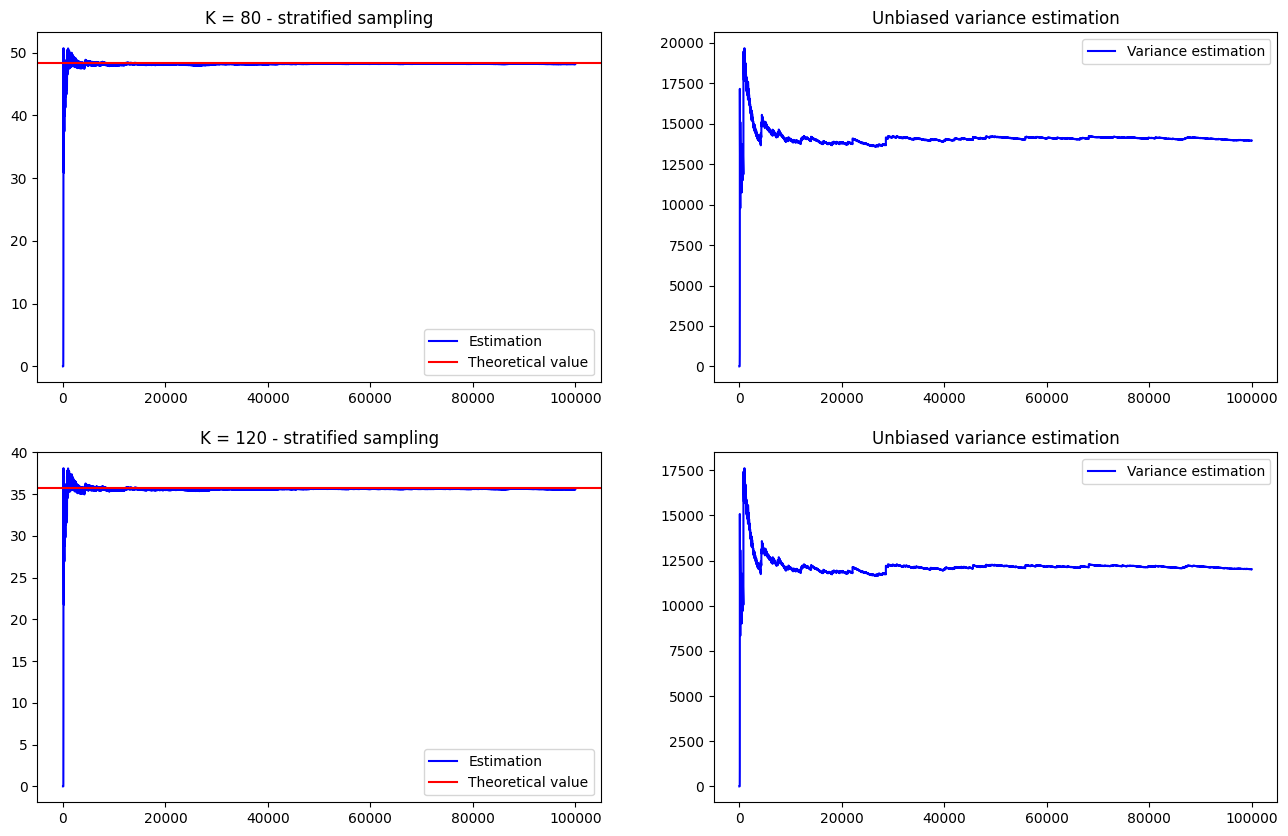

In [68]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [stratified_estimates1, stratified_estimates2], [stratified_variances1, stratified_variances2], [80,120], 'stratified sampling')
#płaskie wykresy wariancji mogą być zasługą bardziej tasowania niż warstwowania, violin-ploty prawdę powiedzą

## 1. e) - importance sampling

100%|██████████| 11/11 [00:49<00:00,  4.50s/it]
/tmp/ipykernel_18871/3507918406.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
/tmp/ipykernel_18871/3507918406.py:29: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")


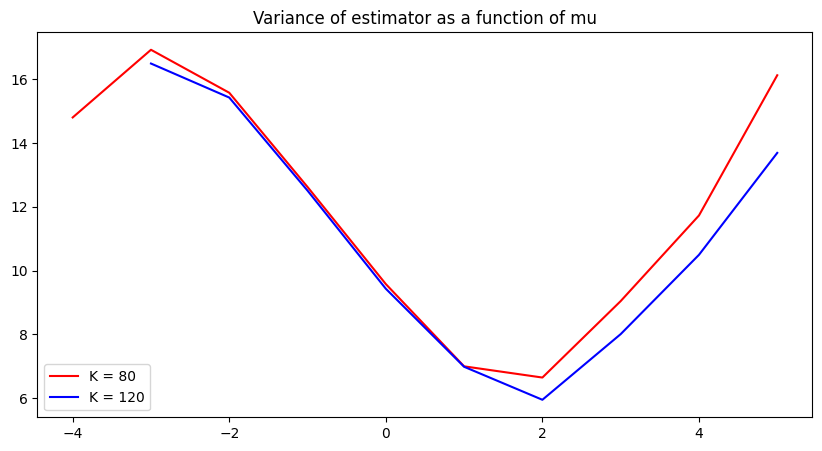

In [44]:
mus = np.linspace(-5,5,11)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()

100%|██████████| 1001/1001 [1:15:31<00:00,  4.53s/it]


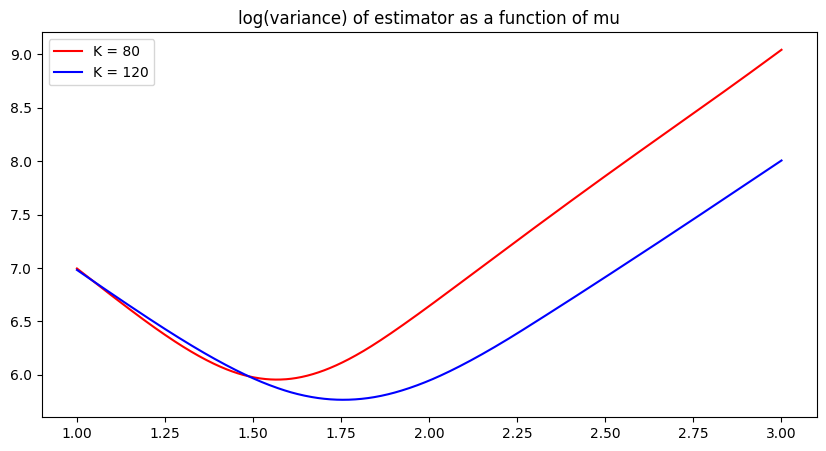

In [45]:
# dalej poszukamy między 1 a 3
mus = np.linspace(1,3,1001)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()
#mu1 ustalimy na 1.6, mu2 na 1.8

In [69]:
mu1 = 1.6
mu2 = 1.8

Y1 = randoms + mu1
Y2 = randoms + mu2

corrections1 = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu1, T) for y in Y1])
corrections2 = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu2, T) for y in Y2])

exponent_Y1 = (sg*np.sqrt(T) * Y1) + (r - (sg**2)/2)*T
exponent_Y2 = (sg*np.sqrt(T) * Y2) + (r - (sg**2)/2)*T

stock_prices_Y1 = S_0*np.exp(exponent_Y1)
stock_prices_Y2 = S_0*np.exp(exponent_Y2)

call_payoffs1_Y1 = stock_prices_Y1 - K_1
call_payoffs2_Y2 = stock_prices_Y2 - K_2

call_payoffs1_Y1[call_payoffs1_Y1 < 0] = 0
call_payoffs2_Y2[call_payoffs2_Y2 < 0] = 0

call_payoffs1_Y1 *= np.exp(-r*T)
call_payoffs2_Y2 *= np.exp(-r*T)

call_payoffs1_Y1 *= corrections1
call_payoffs2_Y2 *= corrections2

imp_samp_cumul_vars1 = calculate_cumulative_variance(call_payoffs1_Y1)
imp_samp_cumul_vars2 = calculate_cumulative_variance(call_payoffs2_Y2)

imp_samp_estimates1 = np.cumsum(call_payoffs1_Y1) / mean_maker
imp_samp_estimates2 = np.cumsum(call_payoffs2_Y2) / mean_maker






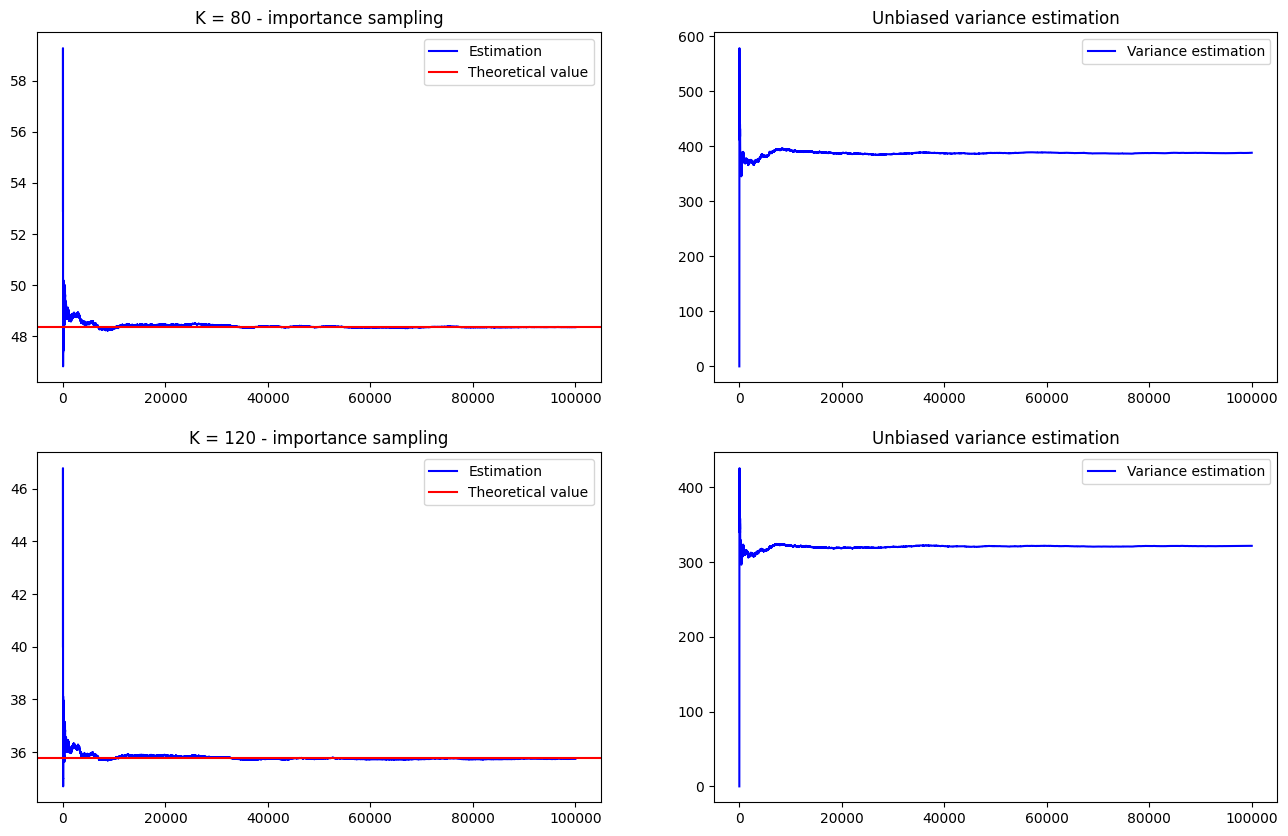

In [70]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [imp_samp_estimates1, imp_samp_estimates2], [imp_samp_cumul_vars1, imp_samp_cumul_vars2], [80,120], 'importance sampling')

## 1. - zbiorcze porównanie

In [71]:
colors = [
    '#FF595E',
    '#FFCA3A',
    '#8AC926',
    '#1982C4',
    '#6A4C93',
    '#FF924C'
]

In [78]:
def limit_array_to_range(array, lower, upper):
    return array[(array > lower) & (array < upper)]

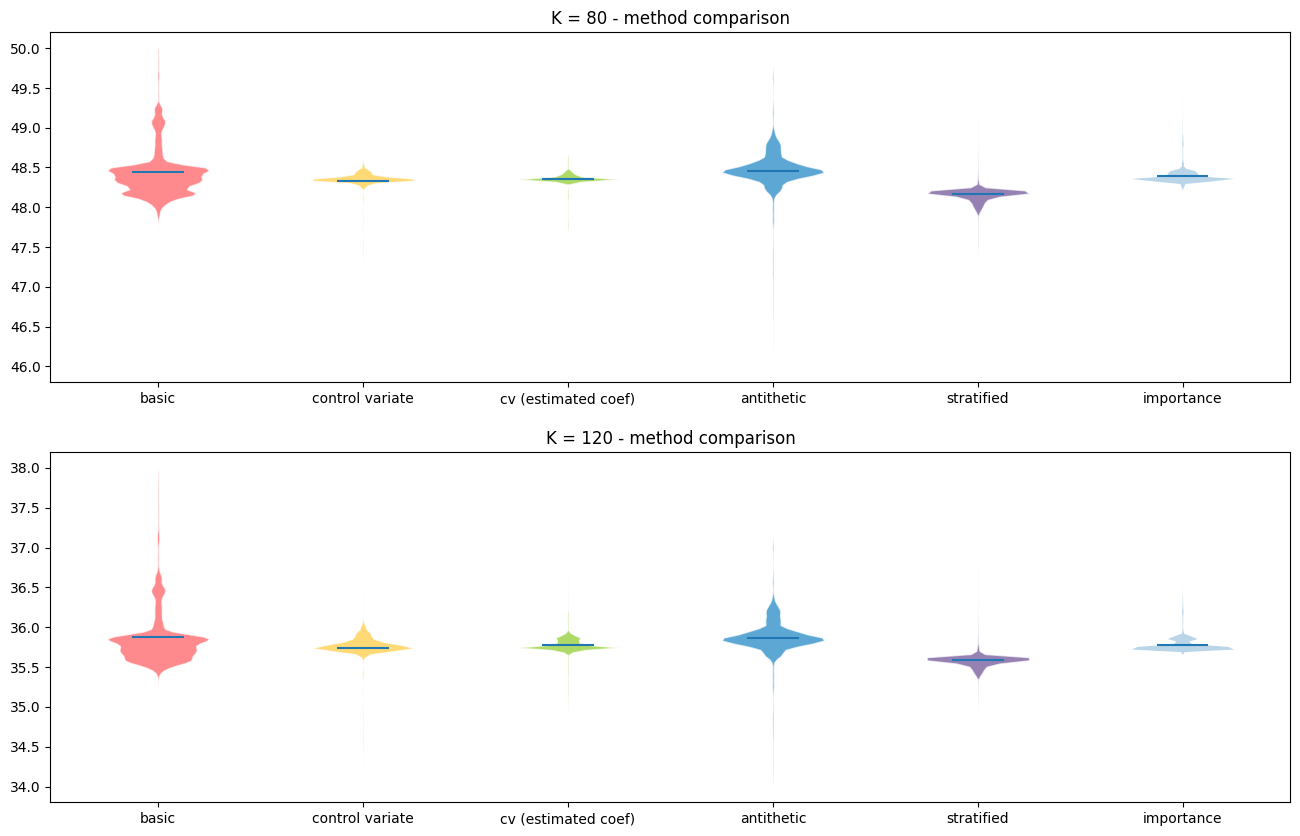

In [79]:
K1_data = [basic_estimates_1, control_variate_estimates_1, control_variate_estimated_coef_estimates1, merged_estimates_1, stratified_estimates_1, imp_samp_estimates1]
K2_data = [basic_estimates_2, control_variate_estimates_2, control_variate_estimated_coef_estimates2,merged_estimates_2, stratified_estimates_2, imp_samp_estimates2]
for i in range(len(K1_data)):
    K1_data[i] = limit_array_to_range(K1_data[i], 46,50)
    K2_data[i] = limit_array_to_range(K2_data[i], 34,38)

ticks = ['basic', 'control variate', 'cv (estimated coef)','antithetic', 'stratified', 'importance']
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
parts = plt.violinplot(K1_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2,3,4,5,6],ticks)
plt.title('K = 80 - method comparison')
plt.subplot(2,1,2)
parts = plt.violinplot(K2_data, showmeans=True, showextrema=False)
for body, color in zip(parts['bodies'], colors):
    body.set_facecolor(color)
    body.set_edgecolor('white')
    body.set_alpha(0.7)
plt.xticks([1,2,3,4,5,6],ticks)
plt.title('K = 120 - method comparison')
plt.show()